# Transfer Learning mit YAMNet zur Klassifizierung von Pump Geräuschen

[YAMNet](https://tfhub.dev/google/yamnet/1) ist ein vortrainiertes tiefes neuronales Netzwerk, das Audio-Ereignisse aus [521 Klassen](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv) vorhersagen kann, wie z.B. Lachen, Bellen oder eine Sirene.

 In diesem Tutorial werden Sie lernen, wie man:

- Laden und Verwenden des YAMNet-Modells für die Inferenz.
- Erstellen eines neuen Modells unter Verwendung der YAMNet-Einbettungen zur Klassifizierung von 'normal' und 'anomaly' Pumpen-Geräuschen.
- Ihr Modell zu evaluieren und zu exportieren.

## TensorFlow und andere Bibliotheken importieren

In [1]:
import os
import sys
sys.path.append("../EchoWatch")
import zipfile
import csv
import random
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

2023-09-28 14:15:36.638472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 14:15:36.860962: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-28 14:15:36.861003: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-28 14:15:37.523810: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Über YAMNet

[YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) ist ein vortrainiertes neuronales Netzwerk, das die tiefenselektierbare Faltungsarchitektur von [MobileNetV1](https://arxiv.org/abs/1704.04861) verwendet. Es kann eine Audiowellenform als Eingabe verwenden und unabhängige Vorhersagen für jedes der 521 Audioereignisse aus dem [AudioSet](http://g.co/audioset) Korpus machen.

Intern extrahiert das Modell "Rahmen" aus dem Audiosignal und verarbeitet Stapel dieser Rahmen. Diese Version des Modells verwendet Rahmen mit einer Länge von 0,96 Sekunden und extrahiert alle 0,48 Sekunden einen Rahmen.

Das Modell akzeptiert ein 1-D float32 Tensor oder NumPy Array, das eine Wellenform beliebiger Länge enthält, dargestellt als einkanalige (mono) 16 kHz Samples im Bereich `[-1.0, +1.0]`. Dieses Tutorial enthält Code, mit dem Sie WAV-Dateien in das unterstützte Format konvertieren können.

Das Modell liefert 3 Ergebnisse, darunter die Klassenwerte, die Einbettungen (die Sie für das Transferlernen verwenden werden) und das log mel [Spektrogramm] (https://www.tensorflow.org/tutorials/audio/simple_audio#spectrogram). Weitere Einzelheiten finden Sie [hier](https://tfhub.dev/google/yamnet/1).

Eine spezifische Verwendung von YAMNet ist als High-Level-Feature-Extraktor - die 1.024-dimensionale Einbettungsausgabe. Sie werden die Eingangsmerkmale des Basismodells (YAMNet) verwenden und sie in Ihr flacheres Modell einspeisen, das aus einer versteckten Schicht "tf.keras.layers.Dense" besteht. Dann trainieren Sie das Netzwerk auf einer kleinen Datenmenge für die Audioklassifizierung, ohne dass Sie eine große Menge an beschrifteten Daten und ein End-to-End-Training benötigen. (Dies ist vergleichbar mit [transfer learning for image classification with TensorFlow Hub] (https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub) für weitere Informationen).

Zuerst werden Sie das Modell testen und die Ergebnisse der Klassifizierung von Audio sehen. Sie werden dann die Datenvorverarbeitungspipeline aufbauen.

### Laden von YAMNet vom TensorFlow Hub

Sie werden ein vortrainiertes YAMNet von [Tensorflow Hub] (https://tfhub.dev/) verwenden, um die Einbettungen aus den Audiodateien zu extrahieren.

Das Laden eines Modells von TensorFlow Hub ist einfach: wählen Sie das Modell, kopieren Sie seine URL und benutzen Sie die Funktion `load`.

Hinweis: Um die Dokumentation des Modells zu lesen, verwenden Sie die Modell-URL in Ihrem Browser.

In [3]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

2023-09-28 14:15:38.917748: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-28 14:15:38.917873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lxd-24q-05): /proc/driver/nvidia/version does not exist
2023-09-28 14:15:38.918644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Wenn das Modell geladen ist, können Sie dem [YAMNet basic usage tutorial] (https://www.tensorflow.org/hub/tutorials/yamnet) folgen und eine WAV-Beispieldatei herunterladen, um die Inferenz durchzuführen.

Sie benötigen eine Funktion zum Laden von Audiodateien, die auch später bei der Arbeit mit den Trainingsdaten verwendet wird. (Erfahren Sie mehr über das Lesen von Audiodateien und deren Labels in [Einfache Audioerkennung](https://www.tensorflow.org/tutorials/audio/simple_audio#reading_audio_files_and_their_labels).

Hinweis: Die von `load_wav_16k_mono` zurückgegebenen `wav_data` sind bereits auf Werte im Bereich `[-1.0, 1.0]` normalisiert (weitere Informationen finden Sie in [YAMNet's documentation on TF Hub](https://tfhub.dev/google/yamnet/1)).

In [4]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## MIMII dataset - Pump dataset

Der MIMII-Datensatz ist eine Sammlung von Geräuschaufnahmen aus der Industrie, die normale und anomale Geräusche von Maschinen wie Ventilen und Pumpen umfasst. Die Aufnahmen wurden mit einer Acht-Kanal-Mikrofonanordnung in realen Fabrikumgebungen erstellt, um eine realistische Darstellung von Industriegeräuschen zu bieten. Dieser Daten-satz dient als Benchmark für die akustische Fehlerdiagnose von Maschinen. (Purohit et al., 2019)

Datensatz herunterladen und extrahieren!


In [5]:
_ = tf.keras.utils.get_file('pump.zip',
                        'https://zenodo.org/record/3678171/files/dev_data_pump.zip?download=1',
                        cache_dir='../',
                        cache_subdir='data',
                        extract=True)

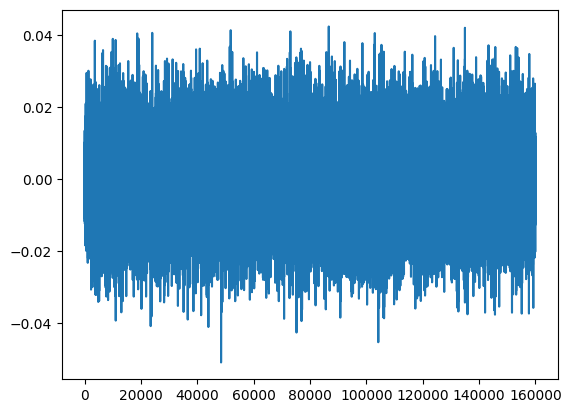

In [8]:
testing_wav_data = load_wav_16k_mono('../data/pump/test/normal_id_00_00000000.wav')

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

### Erkunden Sie die Daten

Die Metadaten für jede Datei sind in der csv-Datei, welche hier vorher noch erstellt werden muss und anschließen in `./datasets/pump/pump.csv` gespeichert wird.

und alle Audiodateien befinden sich in `./datasets/pump/test`

Ein Pandas `DataFrame` mit Mapping wird erstellt um einen besseren Überblick über die Daten zu erhalten.


Hier wird vorher noch eine csv Datei erstellt.
Es wird auch noch eine fold Spalte hinzugefügt für das Cross Validation Verfahren, wo alle Daten in gleichgroße Teilmengen aufgeteilt werden.

In [11]:
audio_dir = '../data/pump/test'
num_folds = 5

file_data = []

#Durchsuche das Verzeichnis und sammle Dateinamen und Klassen
for filename in os.listdir(audio_dir):
    if filename.endswith('.wav'):  #Hier wird angenommen, die Audiodateien haben das Format .wav
        if 'normal' in filename:
            file_data.append((filename, 'normal'))
        elif 'anomaly' in filename:
            file_data.append((filename, 'anomaly'))

random.shuffle(file_data)

fold_size = len(file_data) // num_folds # Größe der Foldteilmenge wird berechnet

# Die Folds werden erstellt
folds = []
for i in range(num_folds):
    fold_start = i * fold_size
    fold_end = (i + 1) * fold_size
    fold_data = file_data[fold_start:fold_end]
    folds.append(fold_data)

# Pfad zur CSV-Datei
csv_file = '../data/pump/pump.csv'

with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['filename', 'category', 'fold']) 

    # Daten werden in die CSV Datei geschrieben
    for fold_index, fold_data in enumerate(folds):
        for filename, label in fold_data:
            writer.writerow([filename, label, fold_index + 1])


In [12]:
pump_csv = '../data/pump/pump.csv'
base_data_path = '../data/pump/test/'

pd_data = pd.read_csv(pump_csv)
pd_data.head()

,filename,category,fold
0,anomaly_id_02_00000059.wav,anomaly,1
1,normal_id_02_00000051.wav,normal,1
2,normal_id_02_00000050.wav,normal,1
3,anomaly_id_00_00000113.wav,anomaly,1
4,normal_id_04_00000094.wav,normal,1


### Filtern Sie die Daten

Jetzt, wo die Daten im `DataFrame` gespeichert sind, wenden Sie einige Transformationen an:

- Filtern Sie die Zeilen heraus und verwenden Sie nur die ausgewählten Klassen - "normal" und "anomal".
- Ändern Sie den Dateinamen so, dass er den vollständigen Pfad enthält. Dies wird das Laden später erleichtern.
- Ändern Sie die Ziele so, dass sie innerhalb eines bestimmten Bereichs liegen. In diesem Beispiel bleibt `normal` auf `0`, aber `anomaly` wird zu `1`.

Übersetzt mit www.DeepL.com/Translator (kostenlose Version)

In [13]:
my_classes = ['normal', 'anomaly']
map_class_to_id = {'normal':0, 'anomaly':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]  #sucht in der Spalte "category" speziell nach dem Inhalt der Liste my_classes also [normal, anomaly]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)
print(filtered_pd.columns)

Index(['filename', 'category', 'fold', 'target'], dtype='object')


### Laden der Audiodateien und Abrufen von Einbettungen

Hier wenden Sie die Funktion `load_wav_16k_mono` an und bereiten die WAV-Daten für das Modell vor.

Wenn Sie Einbettungen aus den WAV-Daten extrahieren, erhalten Sie ein Array der Form `(N, 1024)`, wobei `N` die Anzahl der Frames ist, die YAMNet gefunden hat (einer für jede 0,48 Sekunden Audio).

Ihr Modell wird jeden Rahmen als eine Eingabe verwenden. Daher müssen Sie eine neue Spalte erstellen, die einen Rahmen pro Zeile enthält. Außerdem müssen Sie die Beschriftungen und die Spalte "fold" erweitern, um diese neuen Zeilen korrekt wiederzugeben.

Die erweiterte Spalte "fold" behält die ursprünglichen Werte bei. Sie können keine Frames mischen, da bei der Durchführung der Splits Teile desselben Audios in verschiedenen Splits auftauchen könnten, was Ihre Validierungs- und Testschritte weniger effektiv machen würde.

In [14]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [15]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [16]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Aufteilung des Datensatzes

Verwenden Sie die Spalte "fold", um den Datensatz in Trainings-, Validierungs- und Testdatensätze aufzuteilen.

Der letzte Schritt besteht darin, die Spalte "fold" aus dem Datensatz zu entfernen, da Sie sie beim Training nicht verwenden werden.

In [17]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Erstellen Sie Ihr Modell

Definieren Sie als nächstes ein sehr einfaches [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) Modell mit einer versteckten Schicht und zwei Ausgängen, um 'normal' und 'anomly Geräusche zu erkennen.

In [18]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [19]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [20]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
321/321 [==============================] - 60s 174ms/step - loss: 0.5284 - accuracy: 0.7305 - val_loss: 0.5816 - val_accuracy: 0.7225
Epoch 2/20
321/321 [==============================] - 1s 3ms/step - loss: 0.4577 - accuracy: 0.7797 - val_loss: 0.5532 - val_accuracy: 0.7342
Epoch 3/20
321/321 [==============================] - 1s 3ms/step - loss: 0.4077 - accuracy: 0.8100 - val_loss: 0.5648 - val_accuracy: 0.7298
Epoch 4/20
321/321 [==============================] - 1s 3ms/step - loss: 0.3684 - accuracy: 0.8361 - val_loss: 0.5837 - val_accuracy: 0.7345
Epoch 5/20
321/321 [==============================] - 1s 3ms/step - loss: 0.3392 - accuracy: 0.8467 - val_loss: 0.5790 - val_accuracy: 0.7363
Epoch 6/20
321/321 [==============================] - 1s 3ms/step - loss: 0.3118 - accuracy: 0.8625 - val_loss: 0.5993 - val_accuracy: 0.7526
Epoch 7/20
321/321 [==============================] - 1s 3ms/step - loss: 0.2856 - accuracy: 0.8758 - val_loss: 0.5519 - val_accuracy: 0.7623
Epo

Führen wir die Methode `evaluate` an den Testdaten durch, um sicherzugehen, dass es keine Überanpassung gibt.

In [21]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

107/107 [==============================] - 0s 1ms/step - loss: 0.9501 - accuracy: 0.7386
Loss:  0.9501436352729797
Accuracy:  0.738596498966217


### Visualisierung der Daten

Die Daten werden visualisiert, um Trends, Muster oder Anomalien zu erkennen.

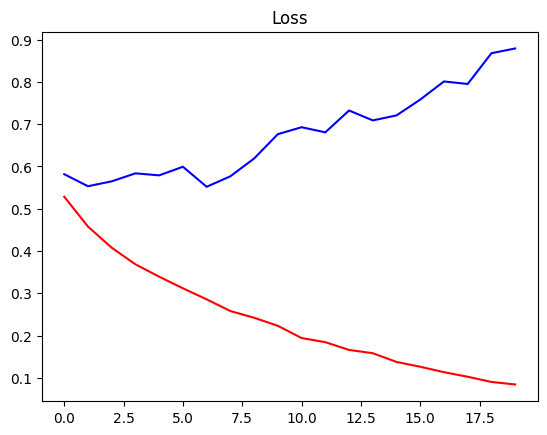

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.show()

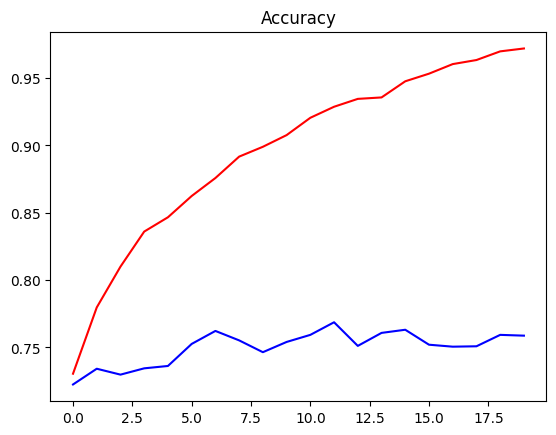

In [25]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')
plt.show()

Sie haben es geschafft!

## Testen Sie Ihr Modell

Als Nächstes testen Sie Ihr Modell mit der Einbettung aus dem vorherigen Test, indem Sie nur YAMNet verwenden.

In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

## Speichern Sie ein Modell, das direkt eine WAV-Datei als Eingabe verwenden kann.

Ihr Modell funktioniert, wenn Sie ihm die Einbettungen als Eingabe geben.

In einem realen Szenario werden Sie Audiodaten als direkte Eingabe verwenden wollen.

Zu diesem Zweck kombinieren Sie YAMNet mit Ihrem Modell zu einem einzigen Modell, das Sie für andere Anwendungen exportieren können.

Um die Verwendung der Ergebnisse des Modells zu erleichtern, wird die letzte Schicht eine `reduce_mean` Operation sein. Wenn Sie dieses Modell zum Servieren verwenden (was Sie später im Lehrgang lernen werden), benötigen Sie den Namen der letzten Ebene. Wenn Sie keinen definieren, wird TensorFlow automatisch einen inkrementellen Namen definieren, was das Testen erschwert, da er sich jedes Mal ändert, wenn Sie das Modell trainieren. Wenn Sie eine rohe TensorFlow Operation verwenden, können Sie ihr keinen Namen zuweisen. Um dieses Problem zu lösen, erstellen Sie einen benutzerdefinierten Layer, der `reduce_mean` anwendet und ihn `classifier` nennt.

In [ ]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [ ]:
saved_model_path = './pump_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

In [ ]:
tf.keras.utils.plot_model(serving_model)

Laden Sie Ihr gespeichertes Modell, um zu überprüfen, ob es wie erwartet funktioniert.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

Und für den letzten Test: Liefert Ihr Modell bei einigen soliden Daten das richtige Ergebnis?

In [ ]:
reloaded_results = reloaded_model(testing_wav_data)
normal_or_anomal = my_classes[tf.math.argmax(reloaded_results)]
print(f'The main sound is: {normal_or_anomal}')

Wenn Sie Ihr neues Modell in einem Serving-Setup ausprobieren möchten, können Sie die Signatur "serving_default" verwenden.

In [ ]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {normal_or_anomal}')
